Описание данных:
- age - возраст покупателей
- DebtRatio - отношение месячных платежей к суммарному месячному доходу
- NumberOfTime30-59DaysPastDueNotWorse - число случаев, когда клиент просрочил выплату на 30-59 дней
- NumberOfTimes90DaysLate - число случаев, когда клиент просрочил на 90+ дней кредит
- NumberOfTime60-89DaysPastDueNotWorse - число случаев, когда клиент просрочил кредит на 60-89 дней
- NumberOfDependents - число иждивенцев
- SeriousDlqin2yrs - целевая переменна

In [16]:
# импортируем необходимые библиотеки
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report, accuracy_score

%matplotlib inline
import matplotlib.pyplot as plt

In [17]:
# загрузим данные
data = pd.read_csv('./data/credit_scoring.csv')
data.head()

,SeriousDlqin2yrs,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,NumberOfTimes90DaysLate,NumberOfTime60-89DaysPastDueNotWorse,MonthlyIncome,NumberOfDependents
0,0,64,0,0.249908,0,0,8158.0,0.0
1,0,58,0,3870.000000,0,0,NaN,0.0
2,0,41,0,0.456127,0,0,6666.0,0.0
3,0,43,0,0.000190,0,0,10500.0,2.0
4,1,49,0,0.271820,0,0,400.0,0.0


Distribution of the target:


SeriousDlqin2yrs
0    0.777511
1    0.222489
Name: count, dtype: float64

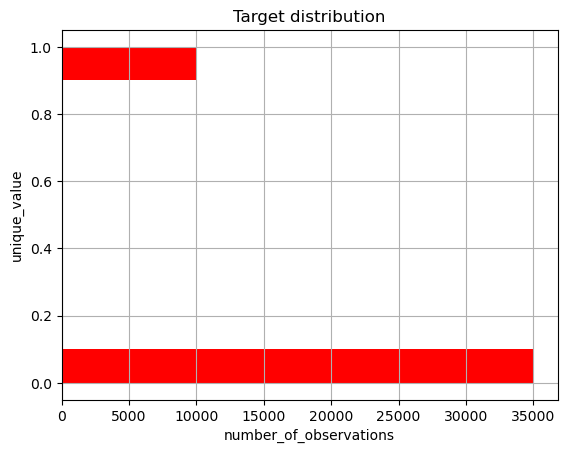

In [18]:
# Посмотрим как выглядит распределение целевой переменной
ax = data['SeriousDlqin2yrs'].hist(orientation='horizontal', color='red')
ax.set_xlabel("number_of_observations")
ax.set_ylabel("unique_value")
ax.set_title("Target distribution")

print('Distribution of the target:')
data['SeriousDlqin2yrs'].value_counts()/data.shape[0]

In [19]:
cols_fill = [col for col in data.columns if col != "SeriousDlqin2yrs"]
for c in cols_fill:
    data[c] = data[c].fillna(data[c].median())

In [20]:
X = data[cols_fill]
y = data['SeriousDlqin2yrs']

In [21]:
lr = LogisticRegression(random_state=13, class_weight='balanced', solver='liblinear')
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=13)

parameters = {'C': (0.0001, 0.001, 0.01, 0.1, 1, 10)}

gs = GridSearchCV(estimator=lr, param_grid=parameters,cv=skf)

---

Задание 3.1

Есть ли разница между средним возрастом вернувших кредит и средним возрастом просрочивших задолженность?

In [22]:
data.head()

,SeriousDlqin2yrs,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,NumberOfTimes90DaysLate,NumberOfTime60-89DaysPastDueNotWorse,MonthlyIncome,NumberOfDependents
0,0,64,0,0.249908,0,0,8158.0,0.0
1,0,58,0,3870.000000,0,0,5166.0,0.0
2,0,41,0,0.456127,0,0,6666.0,0.0
3,0,43,0,0.000190,0,0,10500.0,2.0
4,1,49,0,0.271820,0,0,400.0,0.0


In [23]:
data.groupby("SeriousDlqin2yrs")["age"].mean()

SeriousDlqin2yrs
0    52.723093
1    45.926591
Name: age, dtype: float64

---

Задание 3.2

Подберите коэффициент регуляризации для модели логистической регрессии с помощью GridSearchCV.

In [24]:
lr = LogisticRegression(random_state=13, class_weight='balanced', solver='liblinear')
parameters = {'C': (0.0001, 0.001, 0.01, 0.1, 1, 10)}
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=13)

grid_search = GridSearchCV(
    estimator=lr,
    param_grid=parameters,
    cv=skf,
    n_jobs=-1
)

grid_search.fit(X,y)

grid_search.best_params_

{'C': 0.0001}

---

In [25]:
# 2. Разделение на train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y)

In [51]:
# 3. Применение SMOTE только к тренировочным данным
sm = SMOTE(random_state=42, k_neighbors=3)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

In [52]:
# 4. Обучение модели
model_1 = LogisticRegression()
model_1.fit(X_train_res, y_train_res)
# 5. Предсказание и оценка
y_pred = model_1.predict(X_test)
print(f"Accuracy: {accuracy_score(y_test, y_pred):.2f}")
print(classification_report(y_test, y_pred))

Accuracy: 0.79
              precision    recall  f1-score   support

           0       0.87      0.86      0.86     10511
           1       0.53      0.54      0.53      3008

    accuracy                           0.79     13519
   macro avg       0.70      0.70      0.70     13519
weighted avg       0.79      0.79      0.79     13519



/opt/homebrew/Caskroom/miniconda/base/envs/dlenv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [53]:
# 4. Обучение модели
model_2 = LogisticRegression()
model_2.fit(X_train, y_train)

# 5. Предсказание и оценка
y_pred = model_2.predict(X_test)
print(f"Accuracy: {accuracy_score(y_test, y_pred):.2f}")
print(classification_report(y_test, y_pred))

Accuracy: 0.80
              precision    recall  f1-score   support

           0       0.80      0.99      0.89     10511
           1       0.76      0.15      0.25      3008

    accuracy                           0.80     13519
   macro avg       0.78      0.57      0.57     13519
weighted avg       0.79      0.80      0.74     13519



/opt/homebrew/Caskroom/miniconda/base/envs/dlenv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
